# Практическая работа №3. Свёрточные нейронные сети

**Работу выполнил:**

Румянцев Алексей Александрович, 368731, ПИИ R22 бак 1.1

# Классификация цветов с помощью свёрточных нейронных сетей.


В работе необходимо познакомится с различными архитектурами сверхточных нейронных сетей и их обучением на GPU (англ. graphics processing, графический процессор) на языке программирования Python 3 и фреймворка Torch (PyTorch).  Для этого предлагается использовать ресурсы Google Colab - Colaboratory, для выполнения вычислений на GPU. После с ознакомления, выполнить практическое задане в конце данной тетради (notebook).

Рассмотрим [Датасет](https://www.kaggle.com/alxmamaev/flowers-recognition ) содержащий 4242 изображения цветов размеченных по 5 видам (тюльпан, ромашка, подсолнух, роза, одуванчик). Данный набор данных можно скачать по [ссылке](https://www.kaggle.com/alxmamaev/flowers-recognition ) с сайте kaggle.

Загрузите папку с картинками на гугл диск, чтобы не загружать ее каждый раз заново при перезапуске колаба. Структура файлов (можно посмотреть в меню слева) может быть такой: "/content/drive/My Drive/data/flowers".

Обязательно подключите аппаратный ускоритель (GPU) к среде выполнения. В меню сверху: Среда выполнения -> Сменить среду выполнения.

Первым делом разберите более детально код выполнив код ниже.

# Подготовка

Загружаем библиотеки. Фиксируем random.seed для воспроизводимости.

In [34]:
import numpy as np
import os
from pathlib import Path
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt


random.seed(0)
torch.manual_seed(0)

Выбираем на чем будем делать вычисления - CPU или GPU (cuda).

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Блок для соединения с Google Colab заменен на блок со скачиванием файла в локальную директорию по умолчанию с использованием библиотеки `kagglehub`.

In [ ]:
import kagglehub


# Скачиваем датасет
dataset_path = kagglehub.dataset_download("alxmamaev/flowers-recognition")
print("Dataset downloaded to:", dataset_path)

100%|██████████| 225M/225M [00:21<00:00, 11.2MB/s] 

Extracting files...


Dataset downloaded to: /home/alexexexei/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2


In [26]:
prepare_imgs = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)), # приводим картинки к одному размеру
        torchvision.transforms.ToTensor(), # упаковываем их в тензор
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] # нормализуем картинки по каналам
        ),
    ]
)

image_folder = dataset_path + '/flowers'
# задаем датасет. лейблы - имена папок:
dataset = ImageFolder(image_folder, transform=prepare_imgs)
dataset

Dataset ImageFolder
    Number of datapoints: 4317
    Root location: /home/alexexexei/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [27]:
dataset.imgs[2]

('/home/alexexexei/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2/flowers/daisy/10172379554_b296050f82_n.jpg',
 0)

In [18]:
class ValueMeter(object):
  """
  Вспомогательный класс, чтобы отслеживать loss и метрику
  """
  def __init__(self):
      self.sum = 0
      self.total = 0

  def add(self, value, n):
      self.sum += value*n
      self.total += n

  def value(self):
      return self.sum/self.total

def log(mode, epoch, loss_meter, accuracy_meter, best_perf=None):
  """
  Вспомогательная функция, чтобы
  """
  print(
      f"[{mode}] Epoch: {epoch:0.2f}. "
      f"Loss: {loss_meter.value():.2f}. "
      f"Accuracy: {100*accuracy_meter.value():.2f}% ", end="\n")

  if best_perf:
      print(f"[best: {best_perf:0.2f}]%", end="")


# Сверточная нейросеть с нуля

## Вручную прописываем слои

In [19]:
model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
model.to(device) # отправляем модель на девайс (GPU)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=200704, out_features=1024, bias=True)
  (17): ReLU()
  (18): Linear(in_features=1024, out_features=512, bias=True)
  (19): ReLU()
  (20): Lin

# Задаем параметры и функцию для обучения. Разбиваем датасет на train/validation

Задаем гиперпараметры для обучения:

In [20]:
batch_size = 32
optimizer = torch.optim.Adam(params = model.parameters())
lr = 0.001

Разбиваем датасет на train и validation.

Задаем dataloader'ы - объекты для итеративной загрузки данных и лейблов для обучения и валидации:

In [22]:
train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-1000, 1000])
print('Size of training and validation dataset: ', len(train_set), len(val_set))
loaders = {'training': DataLoader(train_set, batch_size, pin_memory=True,num_workers=2, shuffle=True),
           'validation':DataLoader(val_set, batch_size, pin_memory=True,num_workers=2, shuffle=False)}

Size of training and validation dataset:  3317 1000


Функция для подсчета Accuracy:

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Функция для обучения и валидации модели:

In [ ]:
def trainval(model, loaders, optimizer, epochs=10):
    """
    model: модель, которую собираемся обучать
    loaders: dict с dataloader'ами для обучения и валидации
    """
    loss_meter = {'training': ValueMeter(), 'validation': ValueMeter()}
    accuracy_meter = {'training': ValueMeter(), 'validation': ValueMeter()}

    loss_track = {'training': [], 'validation': []}
    accuracy_track = {'training': [], 'validation': []}

    for epoch in range(epochs): # итерации по эпохам
        for mode in ['training', 'validation']: # обучение - валидация
            # считаем градиент только при обучении:
            with torch.set_grad_enabled(mode == 'training'):
                # в зависимости от фазы переводим модель в нужный режим:
                model.train() if mode == 'training' else model.eval()
                for imgs, labels in tqdm(loaders[mode]):
                    imgs = imgs.to(device) # отправляем тензор на GPU
                    labels = labels.to(device)
                    bs = labels.shape[0]  # размер батча (отличается для последнего батча в лоадере)

                    preds = model(imgs) # forward pass - прогоняем тензор с картинками через модель
                    loss = F.cross_entropy(preds, labels) # считаем функцию потерь
                    acc = accuracy(preds, labels) # считаем метрику

                    # храним loss и accuracy для батча
                    loss_meter[mode].add(loss.item(), bs)
                    accuracy_meter[mode].add(acc, bs)

                    # если мы в фазе обучения
                    if mode == 'training':
                        optimizer.zero_grad() # обнуляем прошлый градиент
                        loss.backward() # делаем backward pass (считаем градиент)
                        optimizer.step() # обновляем веса
            # в конце фазы выводим значения loss и accuracy
            log(mode, epoch, loss_meter[mode], accuracy_meter[mode])

            # сохраняем результаты по всем эпохам
            loss_track[mode].append(loss_meter[mode].value())
            accuracy_track[mode].append(accuracy_meter[mode].value())
    return loss_track, accuracy_track

# Обучаем базовую модель

Проверим загрузку видеокарты, прежде чем запустить обучение.

Запускаем обучение на 10 эпох:

In [ ]:
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs = 10)

100%|██████████| 104/104 [05:05<00:00,  2.94s/it]


[training] Epoch: 0.00. Loss: 1.48. Accuracy: 32.41% 


100%|██████████| 32/32 [00:28<00:00,  1.12it/s]


[validation] Epoch: 0.00. Loss: 1.31. Accuracy: 38.60% 


100%|██████████| 104/104 [05:29<00:00,  3.17s/it]


[training] Epoch: 1.00. Loss: 1.39. Accuracy: 37.17% 


100%|██████████| 32/32 [00:30<00:00,  1.05it/s]


[validation] Epoch: 1.00. Loss: 1.29. Accuracy: 40.60% 


100%|██████████| 104/104 [05:47<00:00,  3.35s/it]


[training] Epoch: 2.00. Loss: 1.35. Accuracy: 39.27% 


100%|██████████| 32/32 [00:33<00:00,  1.04s/it]


[validation] Epoch: 2.00. Loss: 1.28. Accuracy: 41.37% 


100%|██████████| 104/104 [06:49<00:00,  3.94s/it]


[training] Epoch: 3.00. Loss: 1.31. Accuracy: 41.45% 


100%|██████████| 32/32 [00:46<00:00,  1.44s/it]


[validation] Epoch: 3.00. Loss: 1.29. Accuracy: 41.70% 


100%|██████████| 104/104 [07:05<00:00,  4.09s/it]


[training] Epoch: 4.00. Loss: 1.27. Accuracy: 43.61% 


100%|██████████| 32/32 [00:34<00:00,  1.08s/it]


[validation] Epoch: 4.00. Loss: 1.30. Accuracy: 41.96% 


100%|██████████| 104/104 [06:56<00:00,  4.00s/it]


[training] Epoch: 5.00. Loss: 1.22. Accuracy: 46.31% 


100%|██████████| 32/32 [00:30<00:00,  1.04it/s]


[validation] Epoch: 5.00. Loss: 1.34. Accuracy: 42.00% 


100%|██████████| 104/104 [06:55<00:00,  3.99s/it]


[training] Epoch: 6.00. Loss: 1.17. Accuracy: 49.14% 


100%|██████████| 32/32 [00:37<00:00,  1.17s/it]


[validation] Epoch: 6.00. Loss: 1.40. Accuracy: 42.19% 


100%|██████████| 104/104 [07:11<00:00,  4.15s/it]


[training] Epoch: 7.00. Loss: 1.11. Accuracy: 51.88% 


100%|██████████| 32/32 [00:37<00:00,  1.18s/it]


[validation] Epoch: 7.00. Loss: 1.52. Accuracy: 42.41% 


100%|██████████| 104/104 [06:30<00:00,  3.76s/it]


[training] Epoch: 8.00. Loss: 1.05. Accuracy: 54.51% 


100%|██████████| 32/32 [00:31<00:00,  1.02it/s]


[validation] Epoch: 8.00. Loss: 1.68. Accuracy: 43.00% 


100%|██████████| 104/104 [07:06<00:00,  4.10s/it]


[training] Epoch: 9.00. Loss: 1.00. Accuracy: 57.03% 


100%|██████████| 32/32 [00:34<00:00,  1.07s/it]

[validation] Epoch: 9.00. Loss: 1.79. Accuracy: 43.35% 


Построим график обучения. Точность на обучающих данных (`training accuracy`) показывает, насколько хорошо модель обучается на тренировочных данных, а точность на валидационных данных (`validation accuracy`) -- насколько хорошо модель обобщается на новых, не использованных для обучения данных (валидационной выборке). В идеале с каждой эпохой оба параметра должны увеличиваться.

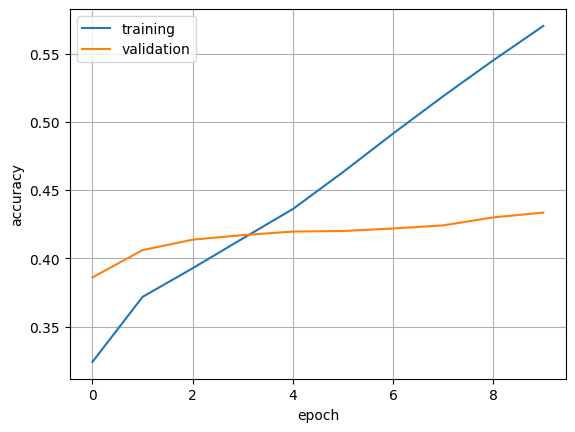

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline


plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

Точность валидации стала значительно медленнее расти после двух эпох и не поднялась выше 45%. Это говорит о переобучении модели -- она просто запомнила тренировочные данные.

Выведем несколько картинок цветов, где подпишем предсказанные метки и истинные.

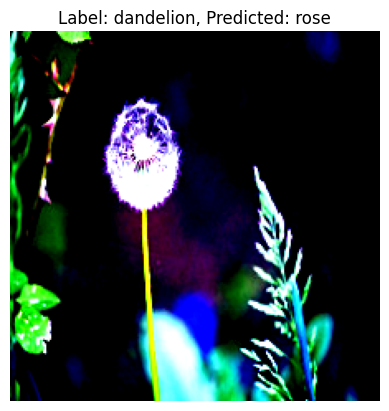

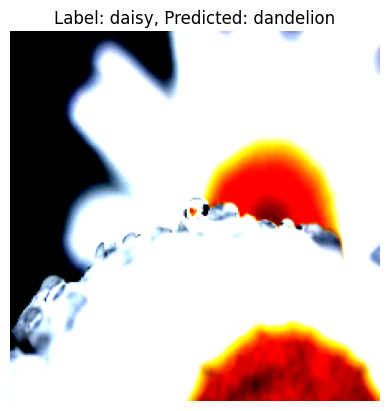

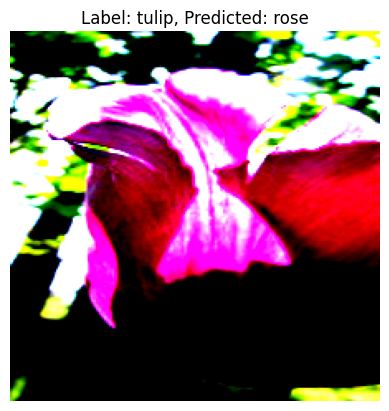

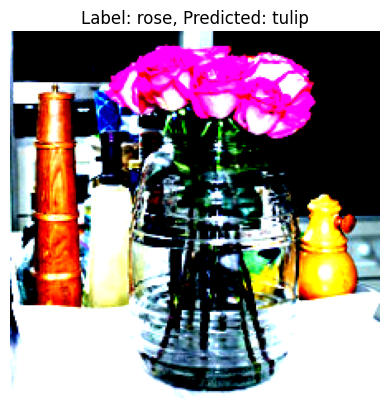

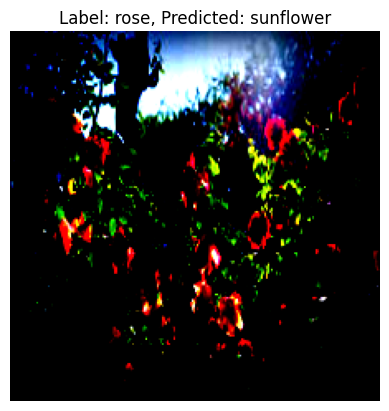

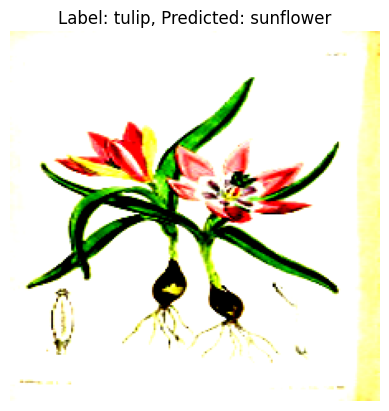

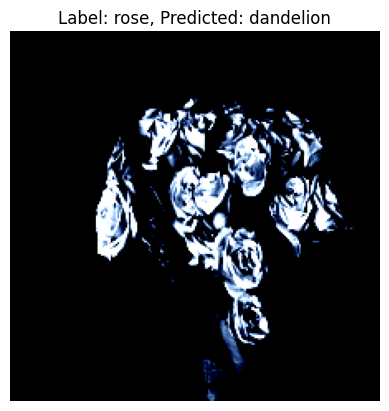

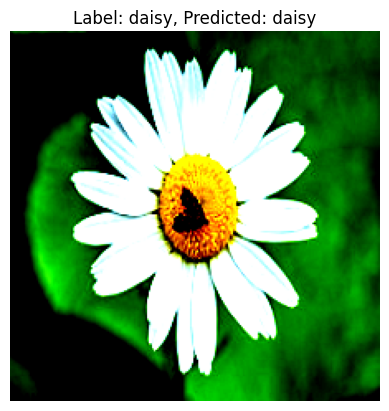

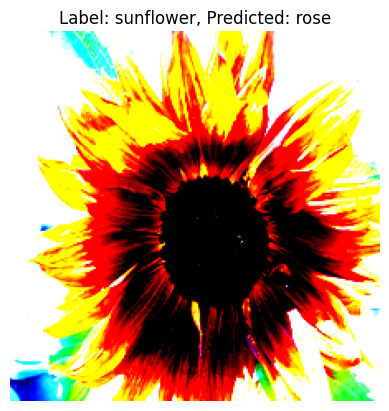

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings


warnings.filterwarnings("ignore")


def predict_image(img, model):
    # преобразование to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # получение прогнозов от модели
    yb = model(xb)
    # выбираем индекс с наибольшей вероятностью
    _, preds  = torch.max(yb, dim=1)
    # получение метки класса
    return dataset.classes[preds[0].item()]


for i in range(1, 10):
  img, label = val_set[i]
  plt.imshow(img.clip(0, 1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, model)))
  plt.show()

# Практическое задание



Выполнять можно как с использованием tensorflow/keras, так и pytorch.

1. Необходимо обучить предобученную сверточную архитектуру для задач классификации цветов.

В выбранной Вами архитектуре также необходимо **разобраться** с основными её параметрами и принципами работы.

Посмотрите как использовать [модели в PyTorch](https://pytorch.org/vision/stable/models.html) для классификации, выберите одну и, используя transfer learning, до-обучите модель на классификацию цветов. Чтобы это сделать замените ____ в ячейках ниже на работающий код.

2. Реализовать свою архитектуру, также как в разделе "Сверточная нейросеть с нуля".

3. Сравнить три архитектуры (из раздела "Сверточная нейросеть с нуля", предобученную сверточную архитектуру и свою архитектуру (из п. 2)). Визуализировать полученный результат сравнения.





**1. Обучение предобученной сверточной архитектуры для задач классификации цветов**

Выберем из списка доступных в PyTorch моделей ResNet50. Укажем в параметрах весы `IMAGENET1K_V2`, которые обладают точностью в 80.858%.

In [31]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2) # pretrained=True -- deprecated
model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/alexexexei/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Передадим модель в функцию для заморозки весов модели, чтобы "заморозить" градиент:

In [32]:
def set_parameter_requires_grad(model):
  for param in model.parameters():
    param.requires_grad = False


set_parameter_requires_grad(model)

Последняя часть сети (последний слой) модели ResNet50 была обучена для другой задачи с иным количеством классов. Нам необходимо поменять последний слой модели. В нашей задаче количество классов (выходов) будет равняться числу категорий (цветов), которые мы классифицируем. Напишем функцию, которая посчитает количество папок (категорий) в папке `flowers` -- это и будет количество выходов.

In [37]:
def count_folders(directory):
    return len([folder for folder in Path(directory).iterdir() if folder.is_dir()])


num_classes = count_folders(image_folder)
num_classes

5

Последний слой модели ResNet50 -- полносвязный (fully connected layer, `fc`). Заменим его на полносвязный слой `nn.Linear`, который реализует линейную трансформацию входных данных в PyTorch, чтобы модель преобразовывала выходной вектор признаков в выходной вектор классов. В этот слой передадим количество признаков (нейронов) `model.fc.in_features` на входе в последний слой (этот параметр зависит от выбранной модели) и количество выходов для нашей задачи.

In [40]:
model.fc = nn.Linear(model.fc.in_features, num_classes)

Проверим, все ли сработало правильно -- выведем веса, которые будут обучаться:

In [41]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

fc.weight
fc.bias


Отправим модель на GPU. Возьмем алгоритм оптимизации `Adam` и 10 эпох, как для базовой модели. Скорость обучения `lr` оставим по умолчанию `1e-3`. Передадим в `trainval` нашу модель и заданные параметры.

In [42]:
model.to(device)
optimizer = torch.optim.Adam(params = model.parameters())
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs = 10)

100%|██████████| 104/104 [00:24<00:00,  4.32it/s]


[training] Epoch: 0.00. Loss: 0.82. Accuracy: 77.75% 


100%|██████████| 32/32 [00:03<00:00,  9.80it/s]


[validation] Epoch: 0.00. Loss: 0.49. Accuracy: 89.50% 


100%|██████████| 104/104 [00:11<00:00,  9.24it/s]


[training] Epoch: 1.00. Loss: 0.62. Accuracy: 83.63% 


100%|██████████| 32/32 [00:03<00:00,  9.59it/s]


[validation] Epoch: 1.00. Loss: 0.43. Accuracy: 90.00% 


100%|██████████| 104/104 [00:11<00:00,  9.10it/s]


[training] Epoch: 2.00. Loss: 0.53. Accuracy: 86.26% 


100%|██████████| 32/32 [00:03<00:00,  9.37it/s]


[validation] Epoch: 2.00. Loss: 0.39. Accuracy: 90.40% 


100%|██████████| 104/104 [00:11<00:00,  9.23it/s]


[training] Epoch: 3.00. Loss: 0.46. Accuracy: 87.86% 


100%|██████████| 32/32 [00:03<00:00,  9.58it/s]


[validation] Epoch: 3.00. Loss: 0.37. Accuracy: 90.78% 


100%|██████████| 104/104 [00:11<00:00,  9.10it/s]


[training] Epoch: 4.00. Loss: 0.42. Accuracy: 89.00% 


100%|██████████| 32/32 [00:03<00:00,  9.49it/s]


[validation] Epoch: 4.00. Loss: 0.35. Accuracy: 90.98% 


100%|██████████| 104/104 [00:11<00:00,  9.18it/s]


[training] Epoch: 5.00. Loss: 0.38. Accuracy: 89.93% 


100%|██████████| 32/32 [00:03<00:00,  9.69it/s]


[validation] Epoch: 5.00. Loss: 0.33. Accuracy: 91.25% 


100%|██████████| 104/104 [00:11<00:00,  8.99it/s]


[training] Epoch: 6.00. Loss: 0.36. Accuracy: 90.68% 


100%|██████████| 32/32 [00:03<00:00,  9.26it/s]


[validation] Epoch: 6.00. Loss: 0.32. Accuracy: 91.46% 


100%|██████████| 104/104 [00:11<00:00,  9.07it/s]


[training] Epoch: 7.00. Loss: 0.33. Accuracy: 91.37% 


100%|██████████| 32/32 [00:03<00:00,  9.69it/s]


[validation] Epoch: 7.00. Loss: 0.31. Accuracy: 91.70% 


100%|██████████| 104/104 [00:11<00:00,  9.08it/s]


[training] Epoch: 8.00. Loss: 0.32. Accuracy: 91.87% 


100%|██████████| 32/32 [00:03<00:00,  9.45it/s]


[validation] Epoch: 8.00. Loss: 0.31. Accuracy: 91.90% 


100%|██████████| 104/104 [00:11<00:00,  9.08it/s]


[training] Epoch: 9.00. Loss: 0.30. Accuracy: 92.34% 


100%|██████████| 32/32 [00:03<00:00,  9.70it/s]

[validation] Epoch: 9.00. Loss: 0.30. Accuracy: 92.08% 


Построим аналогичный график зависимости точности от эпохи.

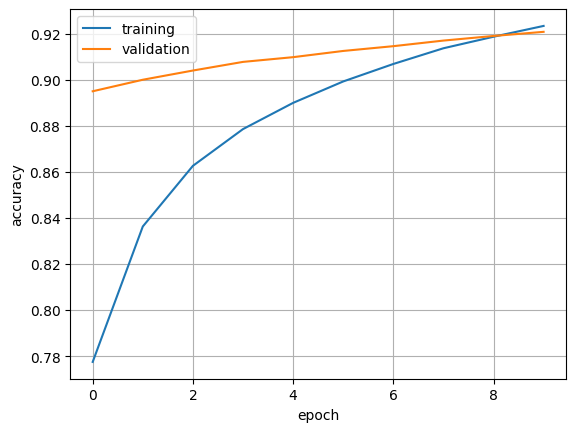

In [43]:
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

Валидационная точность значительно выше тренировочной большую часть эпох. В конце обе точности примерно сходятся. В данном случае модель хорошо обучилась без ярко выраженных проблем по типу недообучения или переобучения.

Выведем несколько картинок цветов с предсказанными и истинными метками.

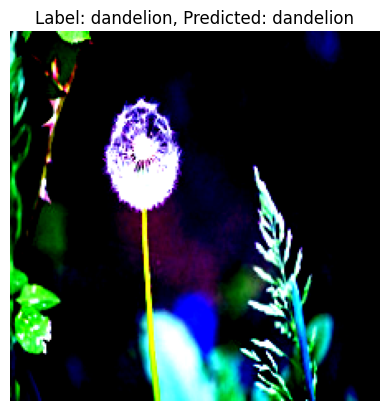

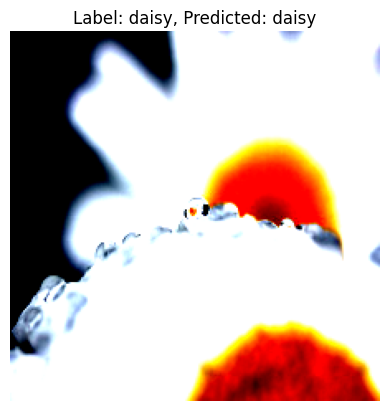

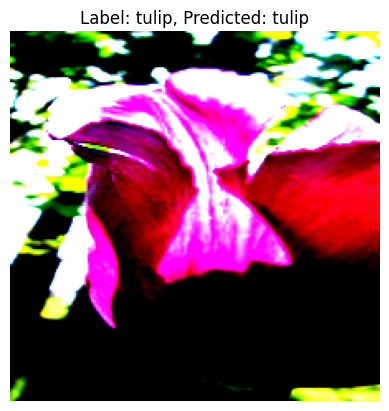

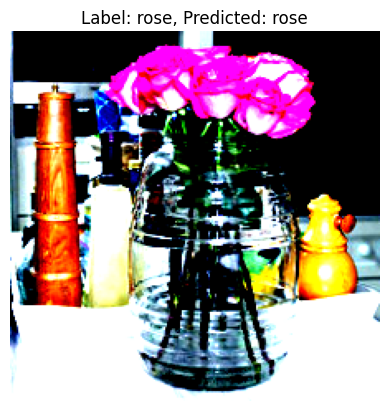

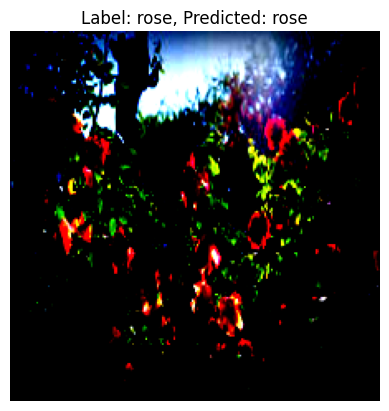

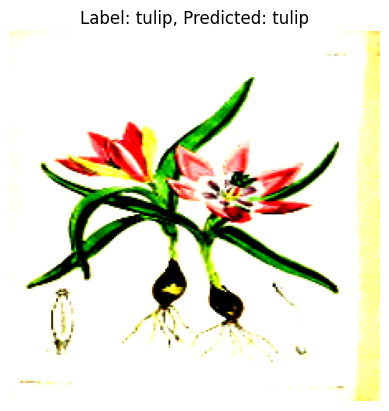

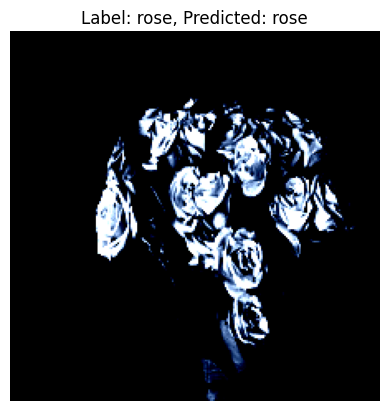

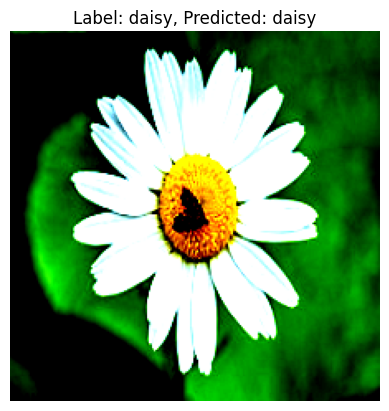

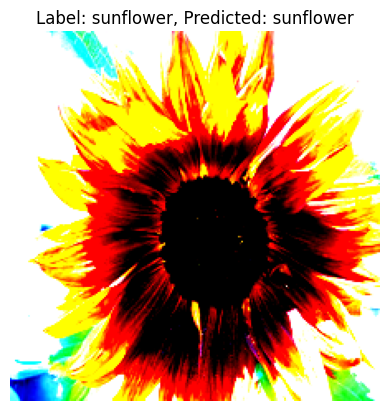

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings


warnings.filterwarnings("ignore")


def predict_image(img, model):
    xb = img.unsqueeze(0).to(device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]


for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, model)))
  plt.show()

Как видим, предсказанные и истинные метки совпадают.

По желанию, можно сохранить веса модели.

In [45]:
weights_fname = f'{Path().resolve()}/model_weights.pth'
torch.save(model.state_dict(), weights_fname)

**2. Своя архитектура**

In [ ]:
# Написать свой код здесь






**3. Сравнение и вузуализация 3-х архитектур**

In [ ]:
# Написать свой код здесь






## Вопросы.
Добавте описание архитектуры выбранной Вами предобученой сверточной нейронной сети.

Как работает выбранная вами модель сверточной нейронной сети? Какие параметры?

В чем основные отличия между сверточной нейронной сетью и "обычной" полносвязной нейронной сетью?

Что такое transfer learning? Что такое предобучена нейронная сеть?

Что такое функция для заморозки весов модели?

Как работает блок "Сверточная нейросеть с нуля"? Описать сверточный и пулинговый слой.